In [1]:


# Citations https://www.kaggle.com/code/yusaku5739/strip-ai-processing-images-to-16x256x256-tiles/notebook
import os
import cv2
from tqdm.notebook import tqdm
import zipfile
import numpy as np
import pandas as pd
import glob
from tifffile import TiffFile
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image

TRAIN = '../input/mayo-clinic-strip-ai/train/'
#OUTPUT_FILE = "mayo-clinic-strip-ai-img_16_256_256"
#os.mkdir("/kaggle/working/"+OUTPUT_FILE)
data = pd.read_csv("../input/mayo-clinic-strip-ai/train.csv")
training = data.drop(labels = range(0,54), axis = 0)
#data = data.drop(labels = range(300, 700), axis = 0)
#training = data
img_list = glob.glob(TRAIN + "*.tif")
#for i in data['image_id']:
  #  path = TRAIN+i+".tif"
  #  img_list.remove(path)
    
sz = 256
N = 16
#data.shape
training.shape


(700, 5)

In [2]:
def tile(img):
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    
    if len(img) < N:
        mask = np.pad(mask,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=0)
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
        print(img.shape)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    return img


In [3]:
def read_img(image_file, dset, min_edge_size=4096, verbose=1):
    with TiffFile(os.path.join(image_file)) as tif:
        tif_tags = {}
        for tag in tif.pages[0].tags.values():
            name, value = tag.name, tag.value
            tif_tags[name] = value
        del tif_tags["TileOffsets"] 
        del tif_tags["TileByteCounts"]
        image = tif.pages[0].asarray()
    
    image_id = image_file.split("/")[-1]
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
    
    min_edge = min(image.shape[:2])
    scale = min_edge//min_edge_size
    
    new_size = (image.shape[1] // scale, image.shape[0] // scale)
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    if image.shape[1]>1.5*image.shape[0]:
        out=cv2.transpose(image)
        image=cv2.flip(out,flipCode=0)
        
    if verbose:
        print(f"[{image_id}] Resized Image shape: {image.shape}")
        
    return image, tif_tags

In [4]:
#for path in tqdm(img_list):
#    img_name = path.split("/")[-1].split(".")[0]
#    img, tags = read_img(path, data, min_edge_size=4096, verbose=False)
#    imgs = tile(img)
 #   np.save("/kaggle/working/" + OUTPUT_FILE + "/" + img_name, imgs)

image before proseccing


<Figure size 432x288 with 0 Axes>

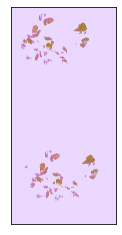



images after proseccing
image shape: (16, 256, 256, 3)



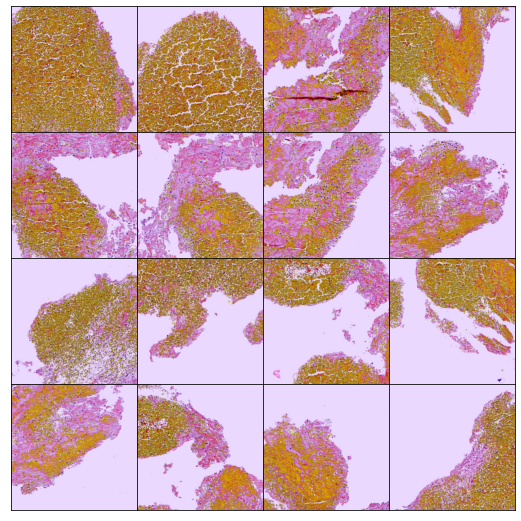

In [5]:
tiles = glob.glob("../input/allprocessed/mayo-clinic-strip-ai-img_16_256_256/*.npy")
ex_id = random.randint(0, len(tiles)-1)
ex_path = tiles[ex_id]

print("image before proseccing")
pre_img, _ = read_img(TRAIN + ex_path.split("/")[-1].split(".")[0] + ".tif", training, min_edge_size=4096, verbose=False)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
shape = [pre_img.shape[0], pre_img.shape[1]]
plt.figure(figsize=(int(shape[0]*0.001), int(shape[1]*0.001)))
plt.imshow(pre_img)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.savefig("pre_img.png")
plt.show()

img = np.load(ex_path)
print("")
print("")
print("images after proseccing")
print(f"image shape: {img.shape}")
print("")

plt.figure(figsize=(7,7))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
for i in range(len(img)):
    plt.subplot(4, 4, i+1).imshow(img[i])
    plt.axis('tight')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
plt.savefig('tiles.png')
plt.show()


In [6]:
from sklearn.preprocessing import LabelEncoder
basedir = '/kaggle/input/mayo-clinic-strip-ai/'
training=pd.concat([training,pd.get_dummies(training['label'])], axis=1)
bi=LabelEncoder()
point=bi.fit_transform(training['label'])
training=training.drop(['label', 'CE', 'LAA'], axis=1)
training=training.assign(label=point)
#df_train.head()
training.head()
training.shape

(700, 5)

In [7]:

output_path = "../input/allprocessed/mayo-clinic-strip-ai-img_16_256_256/"
def _read(df):
    X = []
    
    for i in df['image_id']:
        plt.figure(figsize=(7,7))
        FilePath = output_path + i + '.npy'
        tiles = glob.glob(FilePath)
        if tiles:
            ex_id = random.randint(0, len(tiles)-1)
            ex_path = tiles[ex_id]
            ts = np.load(ex_path)
            plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
            for i in range(len(ts)):
                plt.subplot(4, 4, i+1).imshow(ts[i])
                plt.axis('tight')
                ax = plt.gca()
                ax.axes.xaxis.set_visible(False)
                ax.axes.yaxis.set_visible(False)
            plt.grid(False) 
        
            figs = plt.savefig('temp.jpg')
     
            img = image.load_img("./temp.jpg")
            img = image.img_to_array(img).astype('float32')
            os.remove("./temp.jpg")
            X.append(img)
            plt.close
            plt.clf()
          
        else:
            df = df[df['image_id'] != i]
    return np.array(X), df

#print(path)
X, training = _read(training)
print(X.shape)
Y = training['label']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(700, 504, 504, 3)


<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [8]:
training.shape

(700, 5)

In [9]:
import tensorflow.keras as keras
#from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow import keras
tf.keras.backend.clear_session()
cnn = Sequential([
    Conv2D(8, (3, 3), activation='relu',padding='same',input_shape=(504, 504, 3)),
    MaxPooling2D((2, 2),strides=2),
    Conv2D(16,(5, 5), activation='relu'),
    MaxPooling2D((2, 2),strides=2),
    Dropout(0.2),
    Flatten(),
    Dense(120, activation='relu'),
    Dropout(0.2),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn.summary();
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hd = cnn.fit(X, Y ,batch_size = 22, epochs=30, validation_split = 0.25)

2022-08-16 08:18:27.692588: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 504, 504, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 252, 252, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 16)      3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 124, 124, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 120)               2

2022-08-16 08:18:33.094629: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
24/24 [==============================] - 17s 618ms/step - loss: 990.2744 - accuracy: 0.6133 - val_loss: 1.4646 - val_accuracy: 0.4114
Epoch 2/30
24/24 [==============================] - 14s 565ms/step - loss: 1.2308 - accuracy: 0.6133 - val_loss: 0.7885 - val_accuracy: 0.6057
Epoch 3/30
24/24 [==============================] - 14s 578ms/step - loss: 0.4762 - accuracy: 0.8781 - val_loss: 0.9391 - val_accuracy: 0.6286
Epoch 4/30
24/24 [==============================] - 13s 555ms/step - loss: 0.3048 - accuracy: 0.9143 - val_loss: 1.4697 - val_accuracy: 0.6571
Epoch 5/30
24/24 [==============================] - 13s 563ms/step - loss: 0.2042 - accuracy: 0.9314 - val_loss: 1.7842 - val_accuracy: 0.6343
Epoch 6/30
24/24 [==============================] - 14s 580ms/step - loss: 0.1376 - accuracy: 0.9619 - val_loss: 3.4373 - val_accuracy: 0.6629
Epoch 7/30
24/24 [==============================] - 13s 560ms/step - loss: 0.1429 - accuracy: 0.9657 - val_loss: 1.3649 - val_accuracy: 0.59

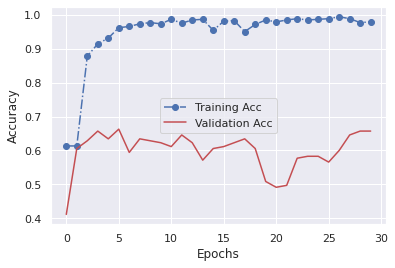

In [10]:
import seaborn as sns
loss_tr = hd.history['accuracy']
loss_va = hd.history['val_accuracy']
epochs = range(0, 30) 



sns.set()

plt.plot(epochs, loss_tr, '-.o', label='Training Acc')
plt.plot(epochs, loss_va, 'r', label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
#Configure Test Data 
TRAIN = '../input/mayo-clinic-strip-ai/test/'
OUTPUT_FILE = "TestDATA"
os.mkdir("/kaggle/working/"+OUTPUT_FILE)
img_tst = glob.glob(TRAIN + "*.tif")
for patht in tqdm(img_tst):
    img_name = patht.split("/")[-1].split(".")[0]
    img, tags = read_img(patht, data, min_edge_size=4096, verbose=False)
    imgs = tile(img)
    np.save("/kaggle/working/" + OUTPUT_FILE + "/" + img_name, imgs)

  0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
#Configure CSV 
df_test = pd.read_csv(basedir+'test.csv')
output_path = "/kaggle/working/TestDATA/"
X_Test,df_test = _read(df_test)
y_Test=cnn.predict(X_Test)

df_submit = df_test.copy()

df_submit['image_id'] = df_test['image_id']
df_submit['center_id'] = np.argmax(y_Test, axis=-1)
df_submit['patient_id'] = df_test['patient_id']
df_submit['image_num'] = df_test['image_num']



<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [13]:
# Seperate the images via patient (see submission example )
df_sub = pd.read_csv(basedir+'sample_submission.csv')
_MySubmit = df_sub.copy()
_MySubmit['patient_id'] = df_test['patient_id']
patient_IDs = df_submit['patient_id'].unique()
CE = []
LAA = []
for i in patient_IDs:
    PatientPhotos = df_submit[df_submit['patient_id'] == i] 
    PatientCE = PatientPhotos[PatientPhotos['center_id']==0]
    PatientLAA = PatientPhotos[PatientPhotos['center_id']==1]
    total = len(PatientPhotos.index)
    totalCE = len(PatientCE.index)
    totalLAA = len(PatientLAA.index)
    CEEP = totalCE/total
    LAAP = totalLAA/total
    _MySubmit.loc[_MySubmit["patient_id"] == i, "CE"] = CEEP
    _MySubmit.loc[_MySubmit["patient_id"] == i, "LAA"] = LAAP
    LAA.append(LAAP)


_MySubmit.head()


,patient_id,CE,LAA
0,006388,1.0,0.0
1,008e5c,1.0,0.0
2,00c058,1.0,0.0
3,01adc5,1.0,0.0


In [14]:
_MySubmit.to_csv('submission_MAYO.csv', index=False)